# Computational Photography - lab 5
### Filip Gromuł

In this assignment we were supposed to use a large dataset of face images to colorize a set of grayscale face images.

As I have recently stumbled upon the newly-opensourced google library [tensorflow](http://tensorflow.org/) for large-scale numerical computations in machine learning, I took this opportunity to test the library doing this exercise.

The assignment took me about 6 hours, but it probably would have taken less if I didn't need to learn a new library while doing it.

Running times were a few minutes for the initial images loading and grayscale descriptors computation, 5 seconds for the PCA, and then about 2 seconds for finding and colorizing each image (with all descriptors already in memory).

I have chosen to perform the color transfer by converting the colored image to the HSV color space, and swapping it's V channel for the grayscale image, obtaining pretty decent results.

Better results yet could be obtained by using a well-researched color transfer algorithm, such as [this](https://github.com/jrosebr1/color_transfer).

I have performed the Principal Component Analysis with 20 components and the results were suprisingly good.
There were some artifacts when compared to the 32x32 descriptors, but it was very insightful to see that such a large reduction in dimensionality may still provide satisfactory results.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


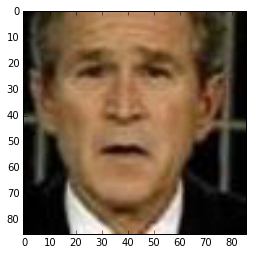

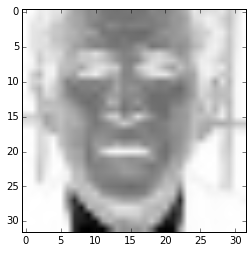

30000

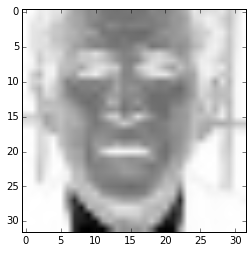

In [2]:
from imageio import imread
from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf

# enqueue all training images
filename_queue = tf.train.string_input_producer([("faces/trainset/%d.jpg" % i) for i in range(1,30177)])
file_reader_instance = tf.WholeFileReader()
filename, image = file_reader_instance.read(filename_queue)

# decode jpeg for original image
decode_jpeg_color = tf.image.decode_jpeg(image, channels=3)

# decode jpeg for grayscale descriptor
decode_jpeg_gray = tf.image.decode_jpeg(image, channels=1)

# resize descriptor to desired size
resized_images = tf.image.resize_images(decode_jpeg_gray, 32, 32)

original_images = []
descriptors = []

with tf.Session() as sess:    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,coord=coord)
    for i in range(1,30177):
        # load and compute all descriptors
        descriptor, orig = sess.run([resized_images, decode_jpeg_color])
        descriptors.append(descriptor)
        original_images.append(orig)
        
        # display every 1000th image
        if (len(descriptors) % 1000) == 0:
            display.clear_output(wait=True)
            plt.imshow(np.squeeze(orig))
            display.display(plt.gcf())
            plt.imshow(np.squeeze(descriptor),cmap='Greys')
            display.display(plt.gcf())
            display.display(len(descriptors))
    coord.request_stop()
    coord.join(threads)

all_descriptors = tf.squeeze(tf.constant(np.array(descriptors)))

In [3]:
import scipy.misc
from imageio import imwrite

# find best match for 32x32 descriptor
def find_best_match(image_filename):
    read_file = tf.read_file(image_filename)
    decode = tf.image.decode_jpeg(read_file, channels=1)
    
    # compute descriptor of loaded image
    resized = tf.squeeze(tf.image.resize_images(decode, 32, 32))
    
    # compute SSD and find the best image
    sum_squares = tf.reduce_sum(tf.square(resized - all_descriptors), [1,2])
    best_image = tf.argmin(sum_squares, 0)
        
    with tf.Session() as sess:        
        return sess.run(best_image)

# recolor an grayscale image using an rgb image
def recolor_image(image_filename, best_match):
    gray_image = imread(image_filename)
    best_color_image = np.copy(original_images[best_match])
    
    # ensure both images are 86x86 (some have 82 in one dimension)
    best_color_image = scipy.misc.imresize(best_color_image, (86,86))
    gray_image = scipy.misc.imresize(gray_image, (86,86))
    
    # convert to hsv color space
    hsv_color_image = matplotlib.colors.rgb_to_hsv(best_color_image/255.0)    
    
    # swap the V channel
    hsv_color_image[:,:,2] = gray_image/255.0
    
    # convert back to rgb
    return matplotlib.colors.hsv_to_rgb(hsv_color_image)

def recolor_all_images():
    for i in range(1,100):
        file_name = "faces/testset/%d.jpg" % i
        im = recolor_image(file_name, find_best_match(file_name))  
        imwrite("faces/results/%d.jpg" % i, im)
        plt.imshow(im)  
        display.clear_output(wait=True)
        display.display(plt.gcf())   


In [26]:
from sklearn.decomposition import PCA

all_descs = np.reshape(np.squeeze(np.array(descriptors)), (30176, 32*32))

# find best 20-dimensional match for 32x32 descriptor
pca = PCA(n_components=20)
%time pca.fit(all_descs)

reduced_descriptors = pca.transform(all_descs)
print reduced_descriptors.shape
reduced_descriptors_const = tf.constant(reduced_descriptors)

def find_best_match_pca(image_filename):
    gray_image = np.reshape(scipy.misc.imresize(imread(image_filename), (32,32)), 1024)
    descriptor = pca.transform(gray_image)
    current_descriptor = tf.constant(descriptor)  
    sum_squares = tf.reduce_sum(tf.square(reduced_descriptors_const - current_descriptor), [1])  
    best_image = tf.argmin(sum_squares, 0)
    with tf.Session() as sess:
        return sess.run(best_image)

def recolor_all_images_pca():
    for i in range(1,100):
        file_name = "faces/testset/%d.jpg" % i
        im = recolor_image(file_name, find_best_match_pca(file_name))  
        imwrite("faces/results/%d.jpg" % i, im)
        plt.imshow(im)  
        display.clear_output(wait=True)
        display.display(plt.gcf())   
        

CPU times: user 28.2 s, sys: 3.65 s, total: 31.9 s
Wall time: 4.52 s
(30176, 20)


In [23]:
def find_all_ordinary():
    for i in range(1,100):
        file_name = "faces/testset/%d.jpg" % i
        im = find_best_match(file_name)

def find_all_pca():
    for i in range(1,100):
        file_name = "faces/testset/%d.jpg" % i
        im = find_best_match_pca(file_name)
                
print "time for ordinary descriptor:"
%time find_all_ordinary()
print "time for pca:"
%time find_all_pca()

time for ordinary descriptor:
CPU times: user 2min 50s, sys: 30.2 s, total: 3min 21s
Wall time: 2min 20s
time for pca:
CPU times: user 2min 23s, sys: 33.8 s, total: 2min 57s
Wall time: 2min 24s
